In [8]:
import numpy as np
import matplotlib.pyplot as plt 

from sklearn import preprocessing

from copy import deepcopy

from importlib import reload
from helpers import *

In [2]:
# import the dataset as a pandas dataframe
fpath = 'Ti-Nb-V-Ta-Fe-Sb_sputtering_data_complete_clean.csv'

df = pd.read_csv(fpath,header=0) 


# if you want to run a model on a reduced parameter set, comment out some of the input training variables
train_variables = ['Ta_power_watts','Sb_power_watts','Nb_power_watts','Ti_power_watts','Fe_power_watts','V_power_watts',
                    'Ta_angle_mm','Sb_angle_mm','Nb_angle_mm','Ti_angle_mm','Fe_angle_mm','V_angle_mm']
predict_variables = ['Ta_measured_percent','Sb_measured_percent','Nb_measured_percent','Ti_measured_percent','Fe_measured_percent','V_measured_percent']
variable_names = ['Ta','Sb','Nb','Ti','Fe','V']

X_all,y_all = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)

X_transformed = np.zeros(X_all.shape)
# scale the X data
for ii,x in enumerate(X_all):
    xScaler = preprocessing.StandardScaler().fit(x.reshape(-1,1))
    X_transformed[ii] = xScaler.transform(x.reshape(-1,1)).reshape(len(x))

# scale the y data
y_transformed = np.zeros(y_all.shape)
Scalers = []

for ii,y in enumerate(y_all):
    Scaler = preprocessing.StandardScaler().fit(y.reshape(-1,1))
    y_transformed[ii] = Scaler.transform(y.reshape(-1,1)).reshape(len(y))
    Scalers.append(Scaler)

X_data = deepcopy(X_transformed.T) 
Y_data = deepcopy(y_transformed.T)
y_original = deepcopy(y_all.T)

In [3]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, WhiteKernel, RationalQuadratic
import matplotlib.pyplot as plt

# I'm going to run this multiple times
# to test the efficiency on different targets
# choose the targets
target_indices = [21,23,24,31,64,66]

all_mae_list = []
all_target_mae = []
all_unc_idx = []

for ii,target_index in enumerate(target_indices):

    # first deep copy the entire datasets
    X_data = deepcopy(X_transformed.T) 
    Y_data = deepcopy(y_transformed.T)
    y_original = deepcopy(y_all.T)

    # identify the target sample
    target_X = deepcopy(X_data[target_index])
    target_y = deepcopy(y_original[target_index])

    # now remove the target sample from the dataset
    X_data = np.delete(X_data,target_index,axis=0)
    Y_data = np.delete(Y_data,target_index,axis=0)
    y_original = np.delete(y_original,target_index,axis=0)

    # Select 5 random initial data point
    np.random.seed(100)
    train_idx = np.arange(0,6)
    train_idx = np.concatenate([train_idx,np.random.choice(range(6,len(X_data)), 5, replace=False)])
    X_train = X_data[train_idx]
    Y_train = Y_data[train_idx]

    # Remaining data
    X_untrained = np.delete(X_data, train_idx, axis=0)
    Y_untrained = np.delete(Y_data, train_idx, axis=0)
    Y_original_untrained = np.delete(y_original, train_idx, axis=0)

    # THIS IS THE BEST KERNEL IVE FOUND SO FAR AS OF 10/23/2023
    # kernel = C(1.0, (1e-6, 1e6)) * Matern(10, (1e-6, 1e6))  + C(1.0, (1e-6, 1e6))*WhiteKernel(10,(1e-6,1e6)) + C(1.0, (1e-6, 1e6))*RationalQuadratic(10)

    kernel = C(1.0, (1e-6, 1e6)) * Matern(10, (1e-6, 1e6)) + C(1.0, (1e-6, 1e6))*RationalQuadratic(10) + C(1.0, (1e-6, 1e6))*WhiteKernel(10,(1e-6,1e6))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Initialize MAE list
    mae_list = []
    target_mae_list = []
    unc_idx = []


    # Main active learning loop
    for i in range(len(X_untrained)):
        # Re-train the GPR model
        gp.fit(X_train, Y_train)
        
        # Make predictions on untrained data
        y_pred, sigma = gp.predict(X_untrained, return_std=True)

        # make predictions on the target
        y_tpred,y_tsigma = gp.predict([target_X],return_std=True)

        y_inverted = []
        y_tinverted = []
        for y,y_t,Scaler,ii in zip(y_pred.T,y_tpred[0],Scalers,range(6)):
            y_inverted.append(Scaler.inverse_transform(y.reshape(-1,1)))
            y_tinverted.append(Scaler.inverse_transform([[y_t]]))
        y_inverted = np.array(y_inverted).T
        y_tinverted = np.array(y_tinverted).T
        
        # Calculate MAE
        mae = np.mean(np.abs(y_inverted - Y_original_untrained))
        mae_list.append(mae)

        # calculate the target MAE
        target_mae = np.mean(np.abs(y_tinverted - target_y))
        target_mae_list.append(target_mae)
        
        # Uncertainty Sampling
        sum_sigma = np.array([np.sum(sig) for sig in sigma]) 
        uncertainty_idx = np.argmax(sum_sigma)
        unc_idx.append(uncertainty_idx)
        
        # Update training and untrained sets
        X_train = np.vstack([X_train, X_untrained[uncertainty_idx]])
        Y_train = np.vstack([Y_train, Y_untrained[uncertainty_idx]])
        X_untrained = np.delete(X_untrained, uncertainty_idx, axis=0)
        Y_untrained = np.delete(Y_untrained, uncertainty_idx, axis=0)
        Y_original_untrained = np.delete(Y_original_untrained, uncertainty_idx, axis=0) 

    all_target_mae.append(target_mae_list)
    all_mae_list.append(mae_list)
    all_unc_idx.append(unc_idx)

c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\M6NJOHNS\AppData\Local\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\User

Text(0, 0.5, 'Mean Absolute Error')

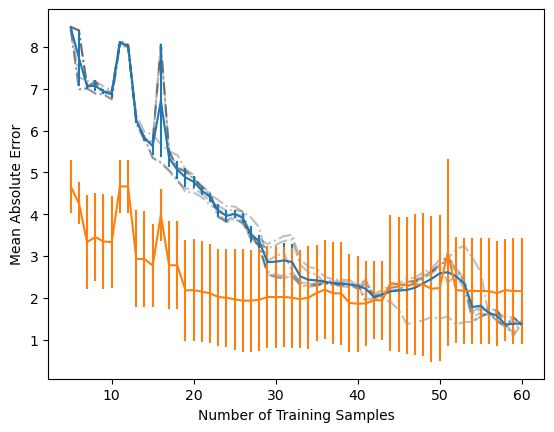

In [4]:
mean_target_mae = np.array([np.mean(array) for array in np.array(all_target_mae).T]) 
mean_mae_list = np.array([np.mean(array) for array in np.array(all_mae_list).T]) 

mean_target_std = np.array([np.std(array) for array in np.array(all_target_mae).T])
mean_mae_std = np.array([np.std(array) for array in np.array(all_mae_list).T]) 


plt.figure()

for mae_list in all_mae_list:
    plt.plot(np.arange(len(mae_list))+5,mae_list,'k-.',alpha=0.25)

plt.errorbar(np.arange(len(mean_mae_list))+5,mean_mae_list,yerr=mean_mae_std,label='Manifold')
plt.errorbar(np.arange(len(mean_target_mae))+5,mean_target_mae,yerr=mean_target_std,label='Target')

plt.xlabel('Number of Training Samples')
plt.ylabel('Mean Absolute Error')

In [5]:
# save the data for generating publication figures
mae_df = pd.DataFrame({'mae':mean_mae_list,'yerr':mean_mae_std})
mae_df.to_csv('errors/GPR_regression_error_averaged_six_runs.csv',index=False)

target_mae_df = pd.DataFrame({'target_mae':mean_target_mae,'yerr':mean_target_std})
target_mae_df.to_csv('errors/GPR_regression_target_error_averaged_six_runs.csv',index=False)